## Loading of Miller ECoG data of motor imagery

includes some visualizations

The first part of the notebook related to the data retrieval and initial visualization was taken from the notebook `MotorImagery` from
https://compneuro.neuromatch.io/projects/ECoG/README.html

In [2]:
# @title Data retrieval
import os, requests

fname = 'motor_imagery.npz'
url = "https://osf.io/ksqv8/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [3]:
# @title Install packages (`nilearn`, `nimare`. `duecredit`), import `matplotlib` and set defaults
# install packages to visualize brains and electrode locations
!pip install nilearn --quiet
!pip install nimare --quiet
!pip install duecredit --quiet

from matplotlib import rcParams
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 25.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.9

In [4]:
# @title Data loading
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat1 = alldat[0][0]
dat2 = alldat[0][1]

print(dat1.keys())
print(dat2.keys())

dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])
dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])


# Dataset info #

This is one of multiple ECoG datasets from Miller 2019, recorded in a clinical settings with a variety of tasks. Raw data and dataset paper are here:

https://exhibits.stanford.edu/data/catalog/zk881ps0522
https://www.nature.com/articles/s41562-019-0678-3

This particular dataset was originally described in this paper:

- Miller, Kai J., Gerwin Schalk, Eberhard E. Fetz, Marcel Den Nijs, Jeffrey G. Ojemann, and Rajesh PN Rao. "Cortical activity during motor execution, motor imagery, and imagery-based online feedback." Proceedings of the National Academy of Sciences (2010): 200913697. doi: [10.1073/pnas.0913697107](https://doi.org/10.1073/pnas.0913697107)

<br>

`dat1` and `dat2` are data from the two blocks performed in each subject. The first one was the actual movements, the second one was motor imagery. For the movement task, from the original dataset instructions:

*Patients performed simple, repetitive, motor tasks of hand (synchronous flexion and extension of all fingers, i.e., clenching and releasing a fist at a self-paced rate of ~1-2 Hz) or tongue (opening of mouth with protrusion and retraction of the tongue, i.e., sticking the tongue in and out, also at ~1-2 Hz). These movements were performed in an interval-based manner, alternating between movement and rest, and the side of move- ment was always contralateral to the side of cortical grid placement.*

<br>

For the imagery task, from the original dataset instructions:

*Following the overt movement experiment, each subject performed an imagery task, imagining making identical movement rather than executing the movement. The imagery was kinesthetic rather than visual (“imagine yourself performing the actions like you just did”; i.e., “don’t imagine what it looked like, but imagine making the motions”).*

<br>

Sample rate is always 1000Hz, and the ECoG data has been notch-filtered at 60, 120, 180, 240 and 250Hz, followed by z-scoring across time and conversion to float16 to minimize size. Please convert back to float32 after loading the data in the notebook, to avoid unexpected behavior.

Both experiments:
* `dat['V']`: continuous voltage data (time by channels)
* `dat['srate']`: acquisition rate (1000 Hz). All stimulus times are in units of this.  
* `dat['t_on']`: time of stimulus onset in data samples
* `dat['t_off']`: time of stimulus offset, always 400 samples after `t_on`
* `dat['stim_id`]: identity of stimulus (11 = tongue, 12 = hand), real or imaginary stimulus
* `dat['scale_uv']`: scale factor to multiply the data values to get to microvolts (uV).
* `dat['locs`]`: 3D electrode positions on the brain surface

In [5]:
from nilearn import plotting
from nimare import utils

plt.figure(figsize=(8, 8))
locs = dat1['locs']
view = plotting.view_markers(utils.tal2mni(locs),
                             marker_labels=['%d'%k for k in np.arange(locs.shape[0])],
                             marker_color='purple',
                             marker_size=5)
view

<Figure size 800x800 with 0 Axes>

In [9]:
# quick way to get broadband power in time-varying windows
from scipy import signal

# pick subject 0 and experiment 0 (real movements)
dat1 = alldat[0][0]

# V is the voltage data
V = dat1['V'].astype('float32')

# high-pass filter above 50 Hz
b, a = signal.butter(3, [50], btype='high', fs=1000)
V = signal.filtfilt(b, a, V, 0)

# compute smooth envelope of this signal = approx power
V = np.abs(V)**2
b, a = signal.butter(3, [10], btype='low', fs=1000)
V = signal.filtfilt(b, a, V, 0)

# normalize each channel so its mean power is 1
V = V/V.mean(0)

In [10]:
# average the broadband power across all tongue and hand trials
nt, nchan = V.shape
nstim = len(dat1['t_on'])

trange = np.arange(0, 4000)
ts = dat1['t_on'][:, np.newaxis] + trange
V_epochs = np.reshape(V[ts, :], (nstim, 4000, nchan))

V_tongue = (V_epochs[dat1['stim_id'] == 11]).mean(0)
V_hand = (V_epochs[dat1['stim_id'] == 12]).mean(0)

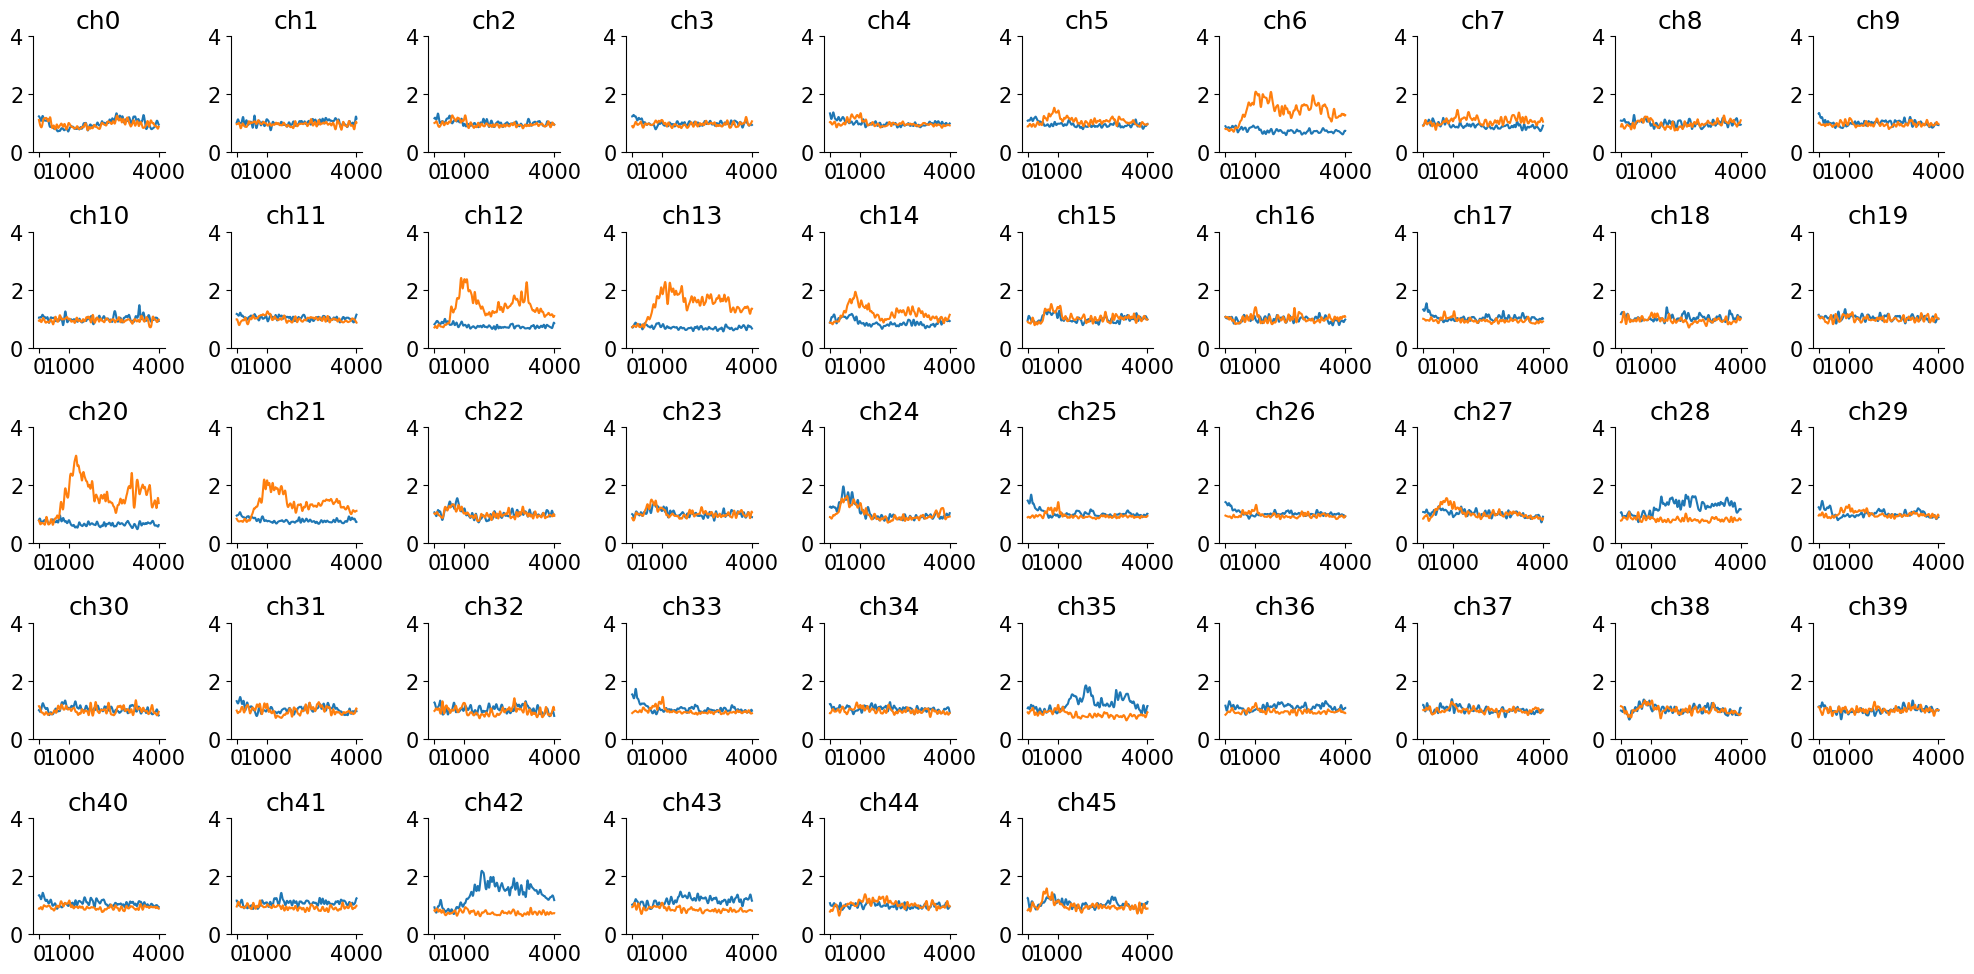

In [12]:
# let's find the electrodes that distinguish tongue from hand movements
# note the behaviors happen some time after the visual cue

plt.figure(figsize=(20, 10))
for j in range(46):
  ax = plt.subplot(5, 10, j+1)
  plt.plot(trange, V_tongue[:, j])
  plt.plot(trange, V_hand[:, j])
  plt.title('ch%d'%j)
  plt.xticks([0, 1000, 4000])
  plt.ylim([0, 4])
plt.show()

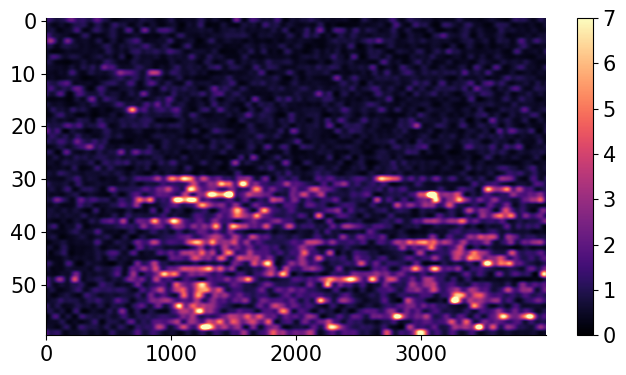

In [13]:
# let's look at all the trials for electrode 20 that has a good response to hand movements
# we will sort trials by stimulus id
plt.subplot(1, 3, 1)
isort = np.argsort(dat1['stim_id'])
plt.imshow(V_epochs[isort, :, 20].astype('float32'),
           aspect='auto',
           vmax=7, vmin=0,
           cmap='magma')
plt.colorbar()
plt.show()

From all sections above we have seen that there is neural activity in certain regions of the brain when extending the hand and moving the tongue.

In the next sections we further explore this signals in more detail

# Real movement

We will explore first when the patients perform real movements.
- Extract relevant features
- Develop a model to classify movements
- Identify areas of the brain activity when performing the tasks (hand or tongue movement)



## Get Features

In [14]:
def get_epochs(signal, nchan, t_on, time):
    signal = signal.T
    chunks = []
    for i in range(len(t_on)):
        t_end = t_on[i]+time
        chunk = signal[:nchan,t_on[i]:t_end]
        chunks.append(chunk)

    return np.array(chunks)

In [15]:
#from sklearn import feature_extraction
import pandas as pd

def get_features(tdfeat, trials=None):
    """tdfeat: 3d features
    """
    features = []
    colnames = ['chan_'+str(ch) for ch in range(tdfeat.shape[1])]
    for t in range(len(trials)): #if trials
        feat = np.mean(tdfeat[t], axis=1)
        features.append(feat)

    df = pd.DataFrame(features)
    df.columns = colnames
    df['target'] = trials
    df['target'] = np.where(df['target']==11, 0, 1)
    return df


We select a subject and filter the signal

In [55]:
from scipy.signal import hilbert

# pick subject 0 and experiment 0 (real movements)
dat1 = alldat[0][0]

# V is the voltage data
V = dat1['V'].astype('float32')

# high-pass filter between 70 and 100 Hz
b, a = signal.butter(3, [70,100], btype='bandpass', fs=1000)
V = signal.filtfilt(b, a, V, 0)

# compute envelope using analytical signal
analytic_signal = hilbert(V)
V_env = np.abs(analytic_signal) # amplitude_envelope

# compute smooth envelope of this signal = approx power
# V_env = np.abs(V)**2
# b, a = signal.butter(3, [10], btype='low', fs=1000)
# V_env = signal.filtfilt(b, a, V_env, 0)

# # normalize each channel so its mean power is 1
# V_env = V_env/V_env.mean(0)

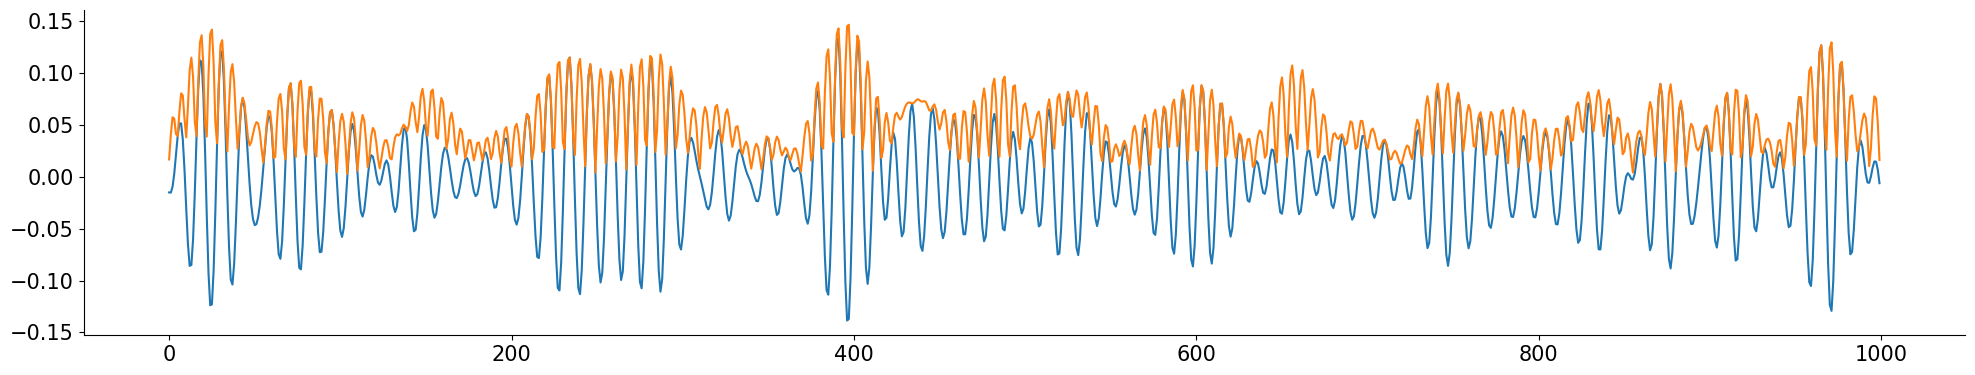

In [56]:
plt.plot(V[:1000,0])
plt.plot(V_env[:1000,0])

In [57]:
feature3d = get_epochs(V_env, 46, dat1['t_on'], 2250)
features = get_features(feature3d, dat1['stim_id'])

In [59]:
features.head()

,chan_0,chan_1,chan_2,chan_3,chan_4,chan_5,chan_6,chan_7,chan_8,chan_9,...,chan_37,chan_38,chan_39,chan_40,chan_41,chan_42,chan_43,chan_44,chan_45,target
0,0.058351,0.055188,0.044528,0.043577,0.048695,0.070066,0.091765,0.086417,0.066955,0.046830,...,0.037231,0.049229,0.043848,0.043939,0.062001,0.068977,0.052837,0.030766,0.044150,1
1,0.054914,0.050466,0.043336,0.047455,0.048677,0.068606,0.095457,0.093981,0.064482,0.042471,...,0.038307,0.048011,0.045073,0.049613,0.061959,0.067107,0.050137,0.030318,0.037355,1
2,0.054469,0.051139,0.040077,0.044123,0.052515,0.077794,0.097537,0.087058,0.058056,0.047909,...,0.041030,0.053950,0.044550,0.043442,0.062327,0.065019,0.047461,0.029778,0.042097,1
3,0.051069,0.053121,0.043433,0.041512,0.047538,0.056216,0.069924,0.073680,0.063513,0.042295,...,0.036412,0.043625,0.047597,0.049348,0.069752,0.088957,0.066779,0.033577,0.041301,0
4,0.065043,0.057864,0.045073,0.048310,0.058001,0.079508,0.094729,0.090902,0.064653,0.045575,...,0.043145,0.050219,0.050680,0.051986,0.070317,0.074399,0.059273,0.038479,0.048759,1


## Training model

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier


In [61]:

X = features.iloc[:,:46]
y = features['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic Regression

In [62]:
model = LogisticRegression(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [63]:
print(classification_report(y_test, y_pred, target_names=['tongue','hand']))

              precision    recall  f1-score   support

      tongue       0.86      1.00      0.92         6
        hand       1.00      0.83      0.91         6

    accuracy                           0.92        12
   macro avg       0.93      0.92      0.92        12
weighted avg       0.93      0.92      0.92        12



In [64]:
model_fi = permutation_importance(model, X_train, y_train)
model_fi['importances_mean']

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00416667, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00416667, 0.00416667, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00416667,
       0.00416667, 0.00416667, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00416667, 0.00416667, 0.00416667, 0.        ,
       0.        ])

In [65]:
scoring = ['r2']
r_multi = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=0, scoring=scoring)

for metric in r_multi:
    print(f"{metric}")
    r = r_multi[metric]
    for i in r.importances_mean.argsort()[::-1]:
        #if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_train.columns[i]:<8}"
                  f"{r.importances_mean[i]:.3f}"
                  f" +/- {r.importances_std[i]:.3f}")

r2
chan_20 0.042 +/- 0.042
chan_12 0.042 +/- 0.042
chan_21 0.042 +/- 0.042
chan_13 0.042 +/- 0.042
chan_19 0.033 +/- 0.041
chan_43 0.025 +/- 0.038
chan_42 0.025 +/- 0.038
chan_6  0.025 +/- 0.038
chan_28 0.025 +/- 0.038
chan_41 0.008 +/- 0.025
chan_14 0.008 +/- 0.025
chan_18 0.000 +/- 0.000
chan_17 0.000 +/- 0.000
chan_16 0.000 +/- 0.000
chan_15 0.000 +/- 0.000
chan_45 0.000 +/- 0.000
chan_11 0.000 +/- 0.000
chan_10 0.000 +/- 0.000
chan_8  0.000 +/- 0.000
chan_7  0.000 +/- 0.000
chan_5  0.000 +/- 0.000
chan_4  0.000 +/- 0.000
chan_3  0.000 +/- 0.000
chan_2  0.000 +/- 0.000
chan_1  0.000 +/- 0.000
chan_9  0.000 +/- 0.000
chan_22 0.000 +/- 0.000
chan_44 0.000 +/- 0.000
chan_33 0.000 +/- 0.000
chan_40 0.000 +/- 0.000
chan_39 0.000 +/- 0.000
chan_38 0.000 +/- 0.000
chan_37 0.000 +/- 0.000
chan_36 0.000 +/- 0.000
chan_35 0.000 +/- 0.000
chan_34 0.000 +/- 0.000
chan_32 0.000 +/- 0.000
chan_23 0.000 +/- 0.000
chan_31 0.000 +/- 0.000
chan_30 0.000 +/- 0.000
chan_29 0.000 +/- 0.000
chan_27 0.000

### Random Forest

In [66]:
model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [67]:
print(classification_report(y_test, y_pred, target_names=['tongue','hand']))

              precision    recall  f1-score   support

      tongue       0.86      1.00      0.92         6
        hand       1.00      0.83      0.91         6

    accuracy                           0.92        12
   macro avg       0.93      0.92      0.92        12
weighted avg       0.93      0.92      0.92        12



In [69]:
# Feature importances
importances_df = pd.DataFrame({"feature_names" : model.feature_names_in_,
                               "importances" : model.feature_importances_})

importances_df = importances_df.sort_values('importances', ascending = False)
importances_df = importances_df.reset_index()

In [70]:
model_fi = permutation_importance(model, X, y)
model_fi['importances_mean']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

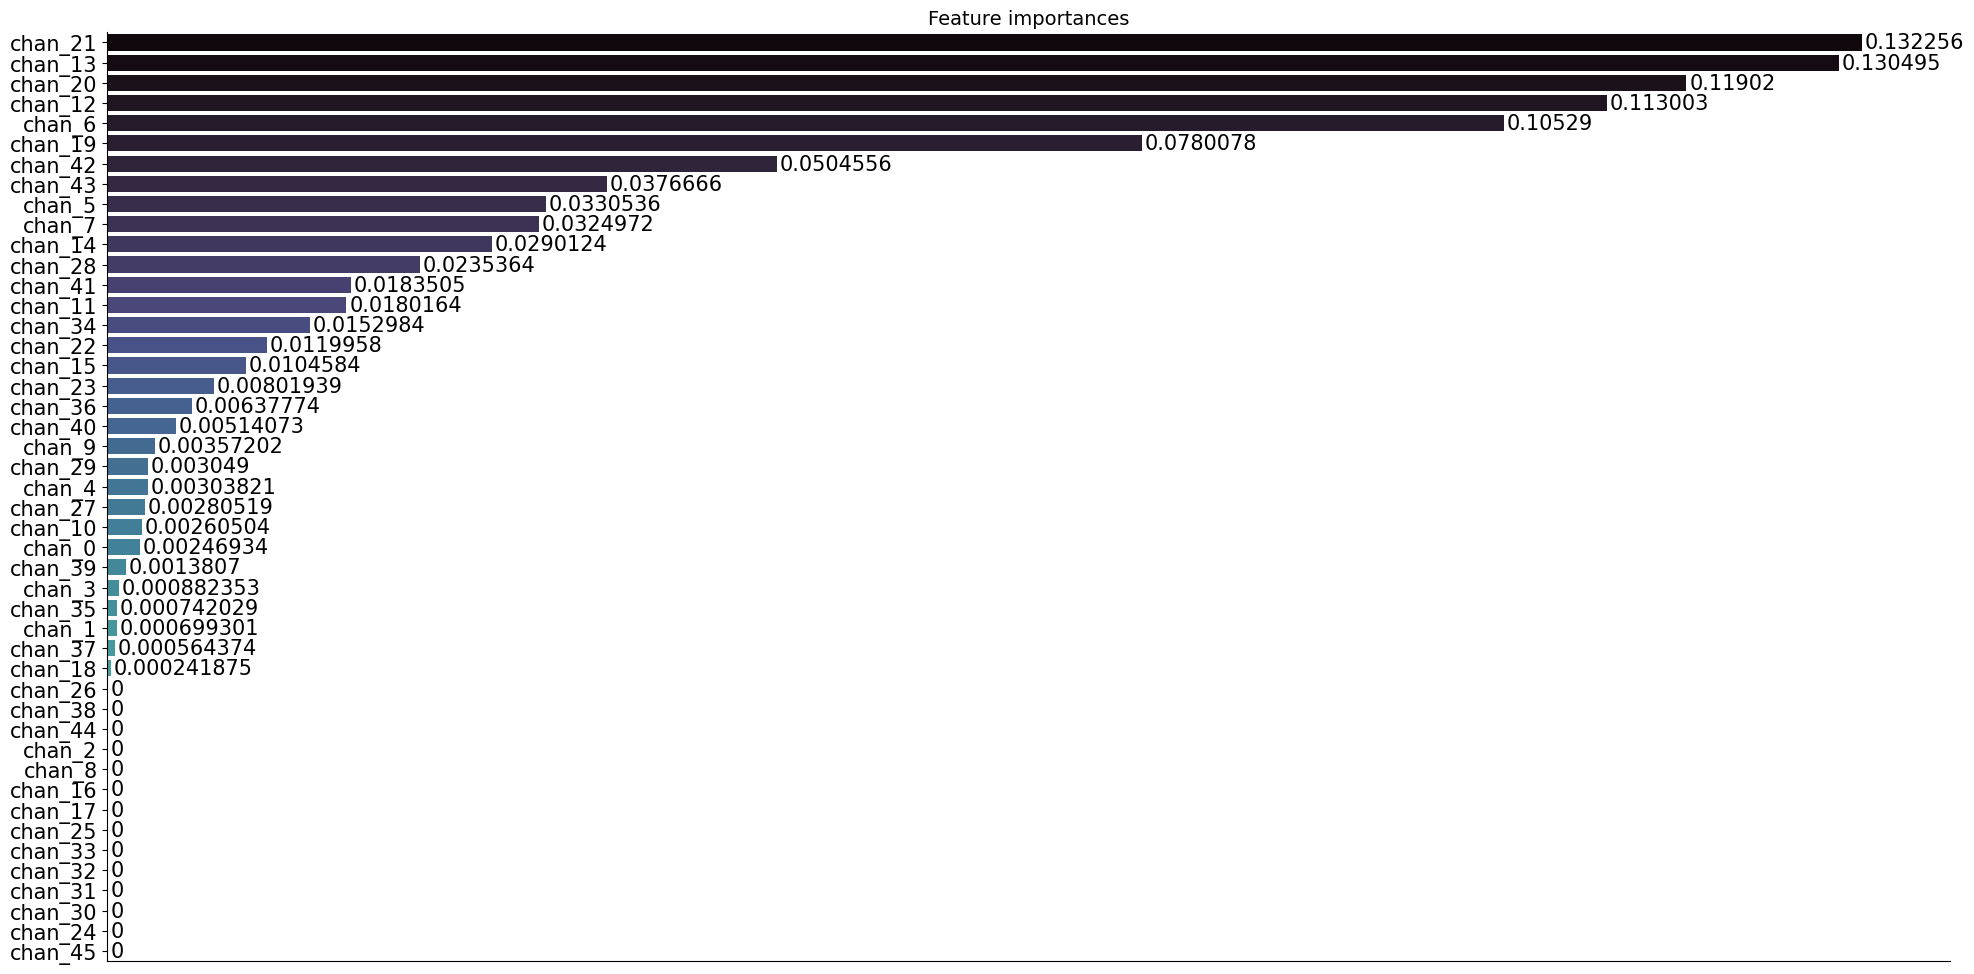

In [71]:
# Visualizing Feature Importance
import seaborn as sns
fig, ax = plt.subplots(figsize=[20, 10])
g = sns.barplot(data=importances_df,
                x="importances",
                y="feature_names",

                # adding mako palette
                palette="mako")
#sns.despine(bottom=True, left=True)
g.set_title("Feature importances", fontsize=14)
g.set(xticks=[])
g.set(xlabel=None)
g.set(ylabel=None)
for value in g.containers:
    g.bar_label(value,
                padding=2)

In [72]:
# Adding information about brain regions
brain_info = pd.DataFrame([dat1['lobe'][:46], dat1['Brodmann_Area'][:46], dat1['locs'][:46]])
brain_info = brain_info.T
brain_info.columns = ['lobe','Brodmann_Area','locs']
brain_info = brain_info.reset_index()

In [73]:
importances_df = pd.merge(importances_df, brain_info, on='index', how='left')

In [74]:
importances_df

,index,feature_names,importances,lobe,Brodmann_Area,locs
0,21,chan_21,0.132256,Parietal Lobe,Brodmann area 3,"[-51.762692884006526, -17.89073546939516, 46.5..."
1,13,chan_13,0.130495,Parietal Lobe,Brodmann area 3,"[-44.51663006442721, -17.750323277457902, 55.4..."
2,20,chan_20,0.119020,Frontal Lobe,Brodmann area 4,"[-53.048448063678904, -7.1483958195745565, 44...."
3,12,chan_12,0.113003,Frontal Lobe,Brodmann area 6,"[-45.99468531575832, -7.667055274640604, 53.64..."
4,6,chan_6,0.105290,Frontal Lobe,Brodmann area 4,"[-35.3607473850193, -17.893669893469085, 63.12..."
5,19,chan_19,0.078008,Frontal Lobe,Brodmann area 6,"[-51.53156961305216, 3.2749719334105194, 42.98..."
6,42,chan_42,0.050456,Frontal Lobe,Brodmann area 6,"[-59.68432941468357, 0.5600427802161327, 11.15..."
7,43,chan_43,0.037667,Parietal Lobe,Brodmann area 43,"[-64.22436959731378, -9.7108816421286, 13.4914..."
8,5,chan_5,0.033054,Frontal Lobe,Brodmann area 6,"[-32.754785176935215, -7.158372861425898, 61.6..."
9,7,chan_7,0.032497,Frontal Lobe,Brodmann area 4,"[-35.477487807256104, -29.273953336960744, 64...."


/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


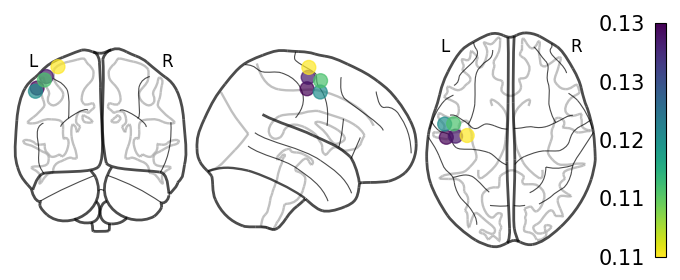

In [75]:
plotting.plot_markers(importances_df['importances'][:5], utils.tal2mni(np.vstack(importances_df['locs'][:5])))

In [ ]:
# 70-100, 100-200
# hilbert pass filter
# wavelet

#paper
# https://www.pnas.org/doi/full/10.1073/pnas.0913697107
# https://www.eneuro.org/content/eneuro/8/3/ENEURO.0007-21.2021.full.pdf
# https://compneuro.neuromatch.io/tutorials/W2D2_LinearSystems/student/W2D2_Intro.html
# https://mikexcohen.com/lectures.html
# https://iopscience.iop.org/article/10.1088/1741-2552/ac4ed1/pdf